# Titanic classification model competition

## 1. Importing libraries

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In this competition, we will try to build, train and deploy a classification model to predicts wheter a passanger survivied or not, given a data set with some features and chacteristics about the passangers.

## 2. Importing data

In [121]:
df_raw_train = pd.read_csv('https://raw.githubusercontent.com/gabrielramos731/Data-science-projects/main/Titanic%20-%20Machine%20Learning%20from%20Disaster/data/train.csv')
df_raw_test = pd.read_csv('https://raw.githubusercontent.com/gabrielramos731/Data-science-projects/main/Titanic%20-%20Machine%20Learning%20from%20Disaster/data/test.csv')

In [122]:
df_train = df_raw_train.copy()
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2.1. Data info

After importing our data, let's take a look at the general info about our data and some descritive statistics.

In [123]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [124]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


As we can see, some columns has an expressive number of NaN values. 

In [125]:
df_train.duplicated().sum()

0

There is no duplicated row in our dataset

## 3. Cleaning the null values

Let's analyze the null values and take the better decision about what to do with these values.

In [126]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

- The feature 'Cabin' has the majority of his values as NaN, so we gonna drop this column.
- The 'Embarked' columns has just two NaN values, so we will complete they with his mode.
- To clean the NaN values of 'Age', we'll complete these values with an adequate groupby operation.

In [127]:
# Drop the 'Cabin' column
df_train.drop('Cabin', axis=1, inplace=True)

In [128]:
# complete the two values of 'Embarked' mode
df_train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [129]:
df_train.loc[df_train['Embarked'].isna(), ['Embarked']] = 'S'

The NaN values from 'Age' column will be completed with the mean of 'Age', grouped by 'Sex', 'Pclass' and 'Embarked' variables.

In [130]:
# Complete NaN values from 'Age'
df_train['Age'] = df_train.groupby(['Sex','Pclass','Embarked'])['Age'].transform(lambda x: x.mean())
df_train.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

---

<AxesSubplot:>

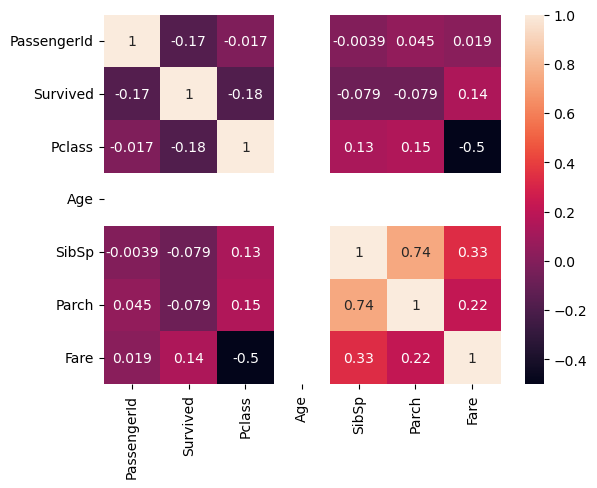

In [131]:
sns.heatmap(df_nan_age.corr(), annot=True)

In [132]:
df_train.groupby(['Sex']).mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Sex,,,,,,,
female,431.028662,0.742038,2.159236,27.269047,0.694268,0.649682,44.479818
male,454.147314,0.188908,2.389948,30.442786,0.429809,0.235702,25.523893


In [133]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked'],
      dtype='object')

In [139]:
colunas = df_train.columns.delete([0,1,3,-1,-3])
colunas

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [140]:
df_train.loc[df_train['Sex'] == 'male', ['Sex']] = 0
df_train.loc[df_train['Sex'] == 'female', ['Sex']] = 1
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,26.574766,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,36.052632,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",1,23.223684,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,33.456522,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",0,26.574766,0,0,373450,8.0500,S


In [141]:
colunas

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [153]:
X_train, X_test, y_train, y_test = train_test_split(df_train[['Fare','Sex']],
                                                    df_train['Survived'],
                                                    test_size=0.2, 
                                                    random_state=1)
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

acuracia = classifier.score(X_test, y_test)
acuracia

C:\Users\ramos\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\ramos\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

0.8156424581005587

In [164]:
df_raw_test.loc[df_raw_test['Sex'] == 'male', ['Sex']] = 0
df_raw_test.loc[df_raw_test['Sex'] == 'female', ['Sex']] = 1

In [166]:
df_raw_test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [167]:
df_raw_test['Age'] = df_raw_test.groupby(['Sex','Pclass','Embarked'])['Age'].transform(lambda x: x.mean())
df_raw_test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [169]:
df_raw_test.loc[df_raw_test['Fare'].isna(), ['Fare']] = df_raw_test['Fare'].mean()

In [170]:
y_pred2 = classifier.predict(df_raw_test[['Fare','Sex']])

C:\Users\ramos\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [172]:
compet_class_df = pd.DataFrame()
compet_class_df['PassengerId'] = df_raw_test['PassengerId']
compet_class_df['Survived'] = y_pred2

In [178]:
compet_class_df.to_csv('C:\ProjetosDS\Data-science-projects\Titanic - Machine Learning from Disaster\submission.csv', index=False)

In [177]:
df_raw_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",0,23.928571,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,22.005152,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",0,52.666667,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",0,24.939605,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.005152,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",0,24.939605,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",1,41.000000,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",0,24.939605,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",0,24.939605,0,0,359309,8.0500,NaN,S


In [174]:
compet_class_df

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
